In [175]:
import requests
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200  

In [161]:
def fetch_graphql_data(endpoint, query, headers=None):
    response = requests.get(endpoint, json={'query': query})
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [162]:
def format_dataframe(df):
    # Custom styles
    styles = {
        # Left-align index
        'selector': 'th',
        'props': [('text-align', 'left')]
    }
    
    # Format 'Total Votes' and apply styles
    return (df.style
            .format({'Total Votes': "{:,.0f}"})
            .set_table_styles([styles]))

In [163]:
def extract_choices(choice_data):
    return {str(key): " ".join(value.split(' - ')[1:]).strip() for key, value in enumerate(choice_data['data']['proposal']['choices'], start=1)}


In [164]:
def get_data(wg):
    choice_query = f"""
    query {{
        proposal(id: "{proposal_ids[wg]}") {{
            votes
            choices
            scores
        }}
    }}
    """

    results_query = f"""
    query {{
        votes(first: 1000, where: {{ proposal: "{proposal_ids[wg]}" }}) {{
            voter
            vp
            choice
        }}
    }}
    """
    
    #get data from snapshot
    
    choice_data = fetch_graphql_data(endpoint, choice_query)
    results_data = fetch_graphql_data(endpoint, results_query)

    return choice_data, results_data

In [165]:
def proccess_voter_choices(results_data):
    df = pd.DataFrame(results_data['data']['votes'])
    df = pd.json_normalize(df.to_dict('records'))
    voter_choices = df.fillna(0).set_index('voter').iloc[:, 1:].rename(columns={f'choice.{i}': str(i) for i in range(1, len(choices) + 1)})
    voter_choices['total'] = voter_choices.sum(axis=1) 
    
    for col in voter_choices.iloc[:,:-1].columns:
        voter_choices[col] = (voter_choices[col] / voter_choices['total'])*100
    voter_choices = voter_choices.iloc[:,:-1]

    return voter_choices

In [166]:
def results(wg='eco'):
    
    #get data from snapshot
    
    choice_data, results_data = get_data(wg)
    
    #process data
    choices = extract_choices(choice_data)

    voter_choices = proccess_voter_choices(results_data)
    
    column_sum = voter_choices.sum()
    non_zero_count = voter_choices.apply(lambda x: (x != 0).sum())


    result = pd.DataFrame({
    'Total Votes': column_sum,
    '# Voters': non_zero_count
    })
    result = result.rename(index=choices)
    
    return format_dataframe(result.sort_values('Total Votes',ascending=False))

In [167]:
def voter_graph(wg):

    heading = {'pg':"Public Goods: ",'eco': "Ecosystem: "}
    
    choice_data, results_data = get_data(wg)
    voter_choices = proccess_voter_choices(results_data)
    non_zero_count = voter_choices.apply(lambda x: (x != 0).sum(),axis=1)

    df = pd.DataFrame(list(non_zero_count.value_counts().sort_index().items()), columns=['Index', 'Value'])

    df['Index'] = df['Index'].astype(str)
    
    mask = df['Index'].astype(int) > 5
    grouped = df[mask].sum(numeric_only=True)
    grouped['Index'] = '5+'
    df = pd.concat([df[~mask], pd.DataFrame([grouped])])
    
    
    def custom_sort(item):
        if item == '5+':
            return 100  
        return int(item)
    
    df['Sort'] = df['Index'].apply(custom_sort)
    df = df.sort_values(by='Sort', ascending=True).drop(columns=['Sort'])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = df.plot.barh(x='Index', y='Value', legend=False, ax=ax)
    plt.xlabel('Voters')
    plt.ylabel('Projects Voted For')
    plt.title(f'{heading[wg]}How many projects did the voters vote for?')
    
    
    for bar in bars.containers:
        ax.bar_label(bar,padding=5)
    
    plt.tight_layout()
    plt.show()

In [168]:
def display_with_title(df, title):
    title_html = f"<h1>{title}</h1>"
    df_html = df.to_html()
    display(HTML(title_html + df_html))

In [169]:
endpoint = "https://hub.snapshot.org/graphql"

In [170]:
proposal_ids = {'eco':"0xfd2b613847557ba419622d480939cb12d880df6f648f6e4489095a71c3002543",
               'pg':'0x1f9519840ebb3974ad5ccb45edf9865e1a5710a2f27ba13ca147251311fdfa26'}

In [171]:
display_with_title(results('pg'),"Small Grants - Public Goods")

,Total Votes,# Voters
Giveth Building the Future of Giving,"1,511",43
Ethereum News by @ethdaily,"1,285",31
dm3 the web3 messaging interoperability protocol,"1,282",36
rotki,"1,166",35
"Pairwise: Simplifying Choices, Amplifying Voices",645,20
EIP-7212 Research,509,24
Arabic Web3 Education,358,15
MetaGame,349,12
BrightID,340,16
Unitap,340,9


In [172]:
display_with_title(results('eco'),"Small Grants - Ecosystem")

,Total Votes,# Voters
ENS Wayback Machine,"1,639",25
1W3 decentralised websites for your ENS,"1,483",37
"Namespace Subname Search, Registration & Issuing","1,303",35
Smart Talk Tech + Talky + ENS = Decentralizing Conversations with AI Intelligence,"1,170",19
NameSys,849,27
L2 ENS Subnames + ERC-4337,576,20
Web3Domains.com | News & Visibility,554,20
HEAVENS TOOLS L.L.C.,488,14
Avatar Sync,487,16
NameGuard,456,20


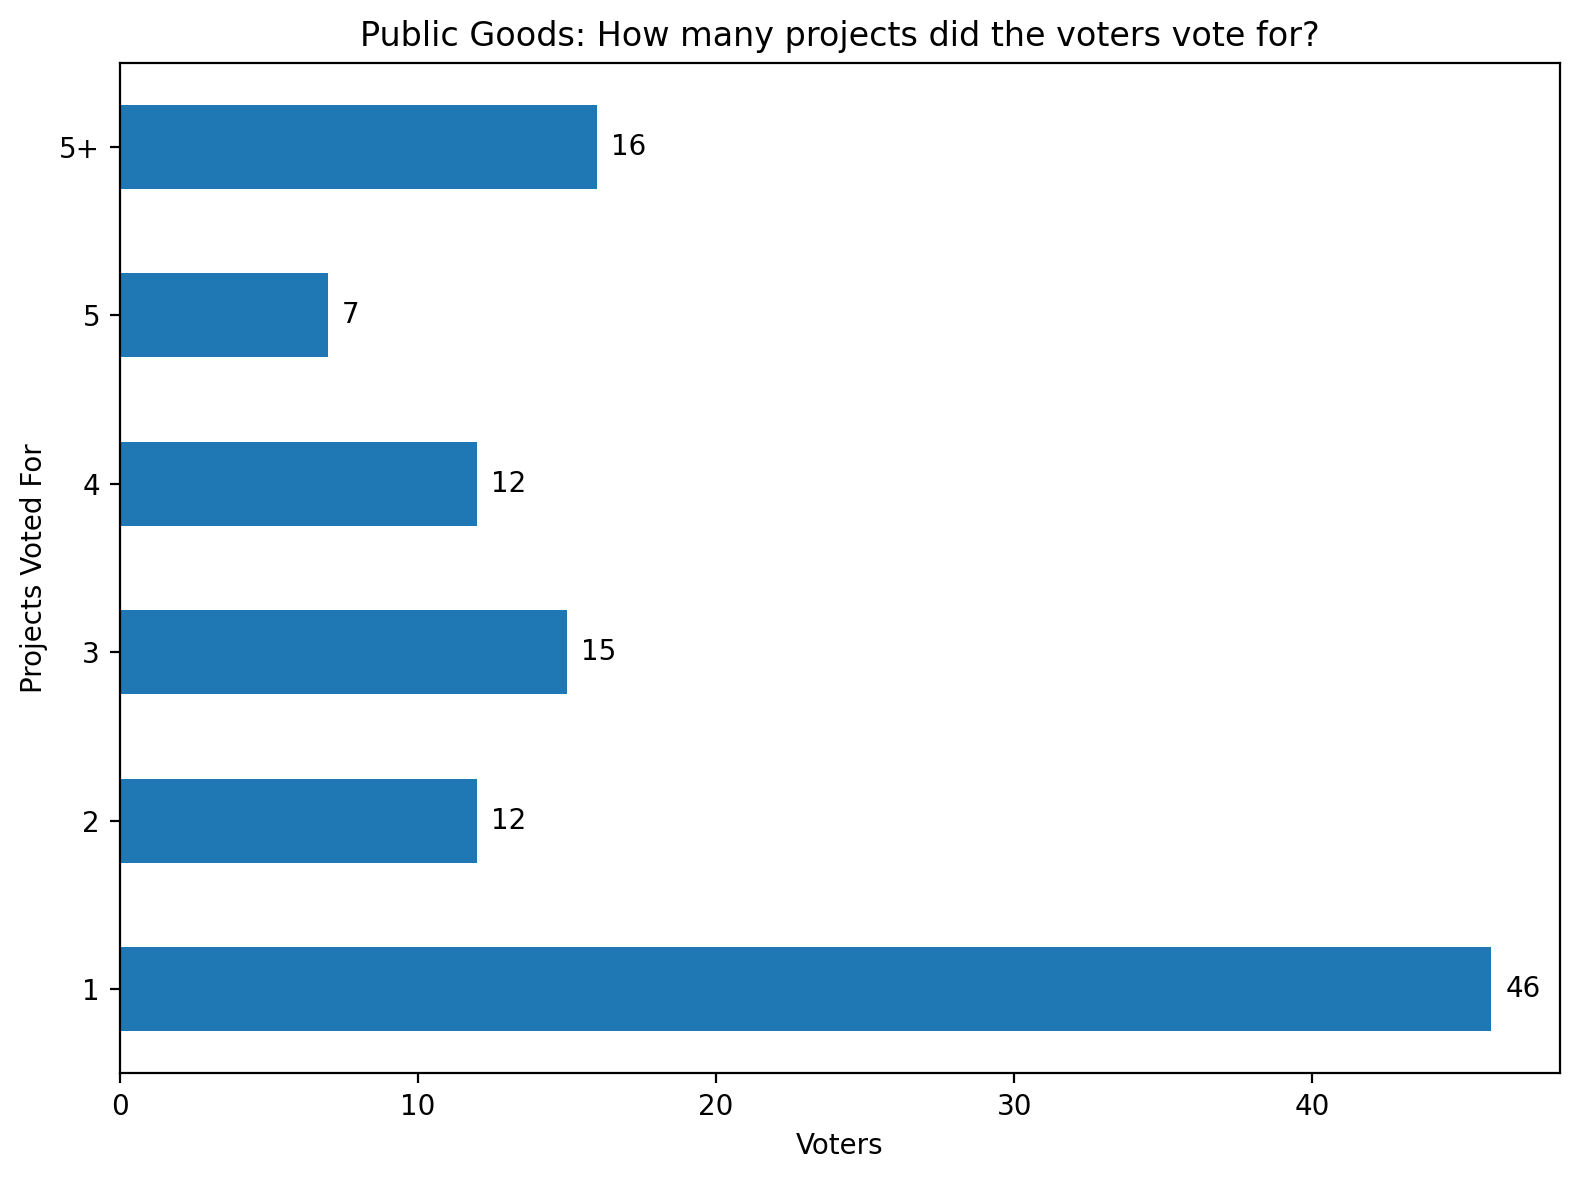

In [176]:
voter_graph('pg')

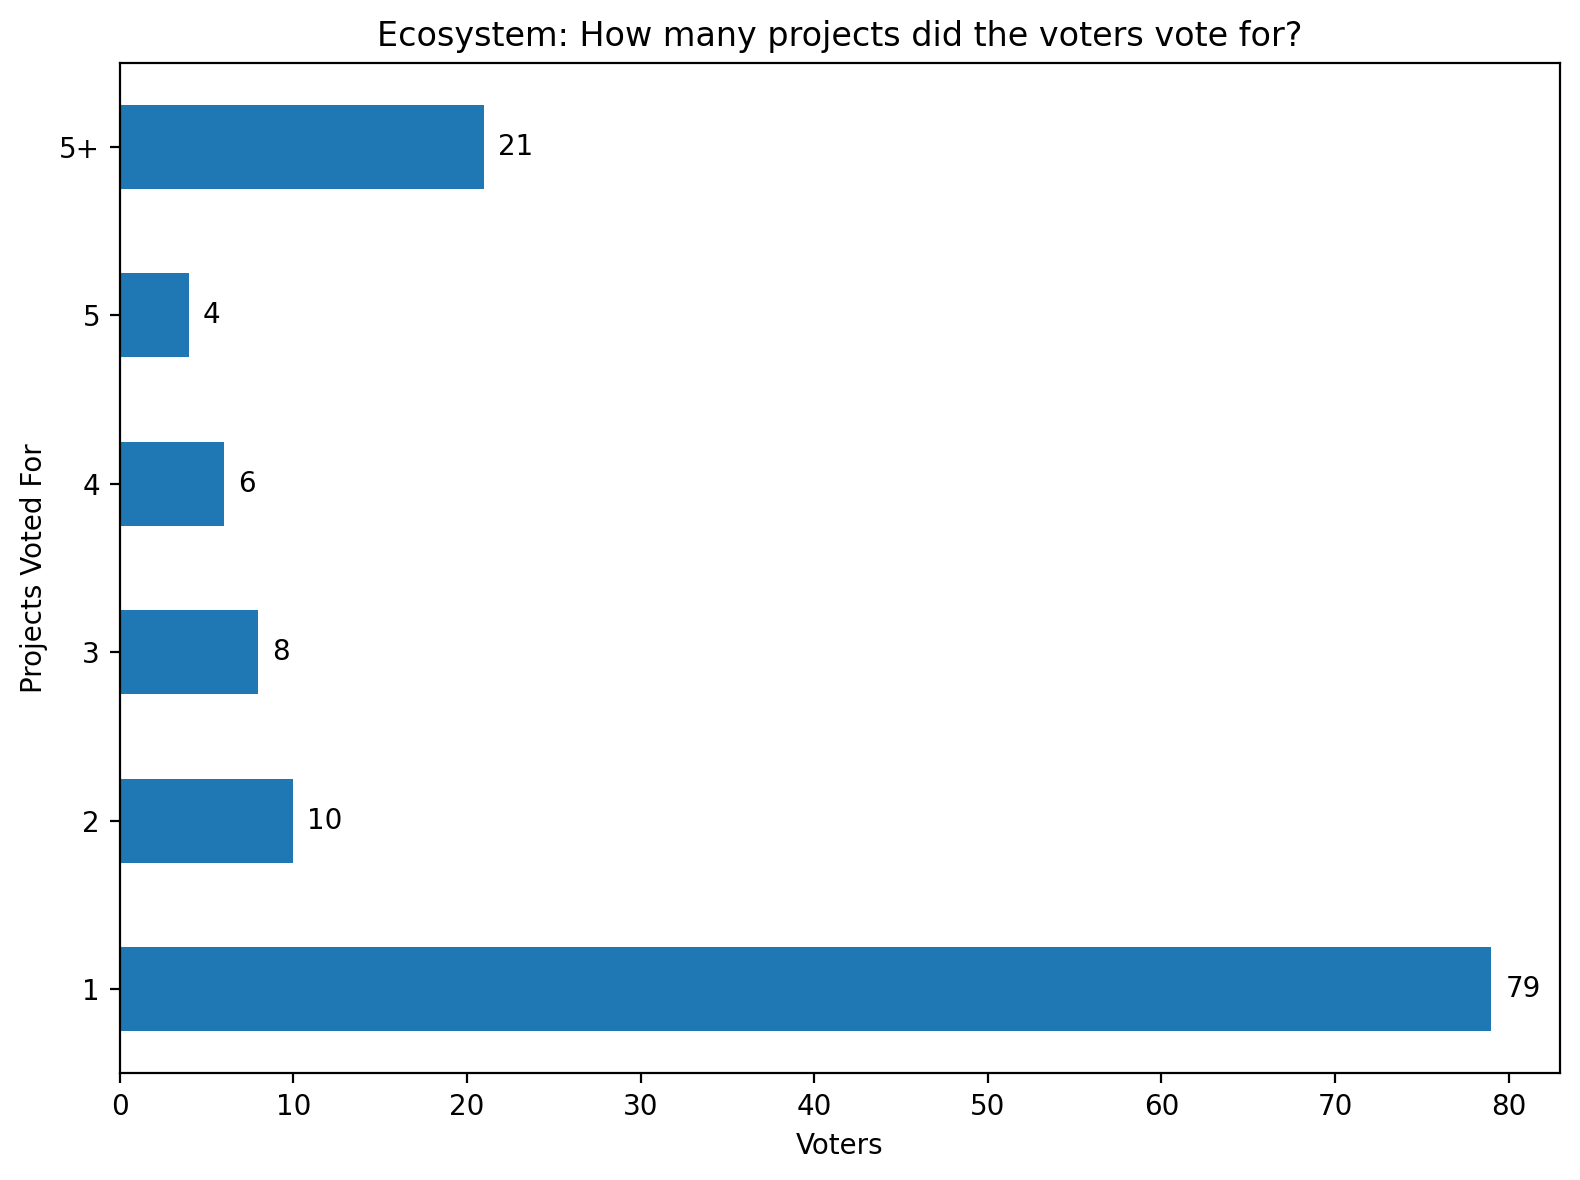

In [177]:
voter_graph('eco')